# ENGR 510: Introduction to Neural Networks
Take the time to make sure you understand each line of this starter code. If you are curious to go beyond the homework questions, we've included some comments to point out where you may want to experiment on your own.

### Cell 1: Python imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For importing the MNIST data set:
from sklearn.datasets import fetch_openml

# For visualizing loop progress:
from tqdm import tqdm

# PyTorch imports:
import torch
from torch import nn
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss, Module
from torch.utils.data import DataLoader, TensorDataset

### Cell 2: Activate the GPU for faster model training

To activate the GPU: \> Runtime \> Change runtime type \> Pick whatever GPU is available.

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
print("^^^^ if cuda is printed, we are using the GPU!")

cpu
^^^^ if cuda is printed, we are using the GPU!


### Cell 3: Load and visualize the MNIST data set

In [3]:
# Load the MNIST data:
mnist = fetch_openml("mnist_784", parser="auto")
X = np.array(mnist.data) / 255.0  # Scale the data to [0, 1]
y = np.array(mnist.target).astype(int)

# Print some data information:
print("MNIST data loaded succesfully!")
print(f"Image data: X.shape = {X.shape}")
print(f"Label data: y.shape = {y.shape}")
print()

MNIST data loaded succesfully!
Image data: X.shape = (70000, 784)
Label data: y.shape = (70000,)



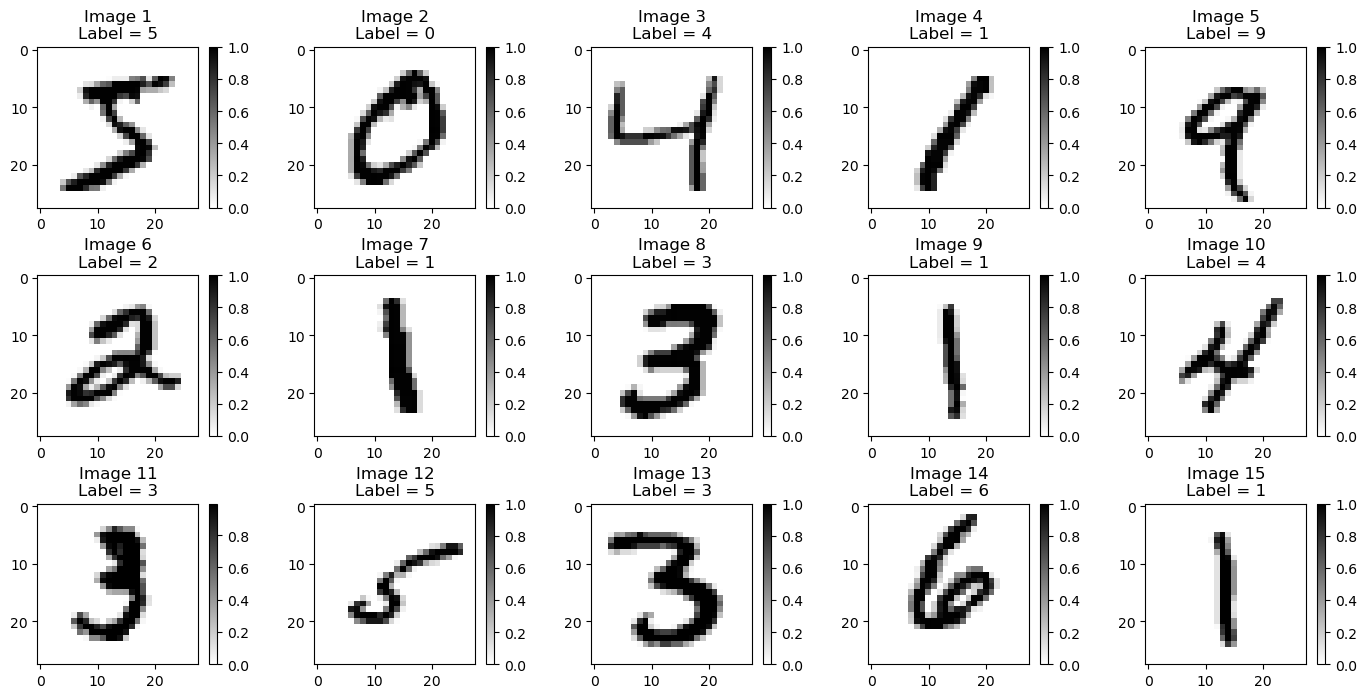

In [4]:
# Plot some of the MNIST images.
plt.figure(figsize=(14, 7))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.title(f"Image {i + 1}\nLabel = {y[i]}")
    plt.imshow(X[i, :].reshape(28, 28), cmap='binary')
    plt.colorbar()
plt.tight_layout()
plt.show()

### Cell 4: Convert the data for use by PyTorch:
- Convert NumPy arrays to PyTorch tensors
- Convert tensor data into PyTorch DataLoaders

In [5]:
# Split the data into a training and a test set.
# Reserve the first n_test samples for testing.
n_test = 7000
X_train = X[n_test:]
y_train = y[n_test:]
X_test = X[:n_test]
y_test = y[:n_test]

In [6]:
# Convert data from NumPy arrays to PyTorch tensors.
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()
print(f"X_train type: {type(X_train)}")
print(f"X_train size: {X_train.size()}")
print()
print(f"y_train type: {type(y_train)}")
print(f"y_train size: {y_train.size()}")

X_train type: <class 'torch.Tensor'>
X_train size: torch.Size([63000, 784])

y_train type: <class 'torch.Tensor'>
y_train size: torch.Size([63000])


In [7]:
# Use data tensors to build PyTorch Datasets.
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Use Datasets to build PyTorch DataLoaders.
batch_size = 128 # <--- BATCH SIZE MIGHT BE GOOD TO EXPERIMENT WITH
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # <--- SHUFFLE/NO SHUFFLE MIGHT BE GOOD TO EXPERIMENT WITH
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Note: DataLoaders are iterable, where each iteration yields a batch of data.
# Grab the first batch from the training loader to see dimensions.
batch_images, batch_labels = next(iter(train_loader))
print(f"batch_images size: {batch_images.size()}")
print(f"batch_labels size: {batch_labels.size()}")

batch_images size: torch.Size([128, 784])
batch_labels size: torch.Size([128])


### Cell 5: Define the neural network architecture.

In [8]:
# Dimensions are 784 (input dimension) -> 64 -> 32 -> 10 (output dimension).
# Note that the input and output dimensions are specific to MNIST.
def my_model() -> nn.Module:
    model = nn.Sequential(
        nn.Linear(784, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 10),
    )
    return model

# <--- NN ARCHITECTURE MIGHT BE GOOD TO EXPERIMENT WITH.

### Cell 6: TRAIN THE MODEL!

In [9]:
# Initialize the neural network model.
# Be sure to load the model onto the GPU.
model = my_model().to(DEVICE)

# Define the loss function.
loss_func = CrossEntropyLoss() # <--- LOSS FUNCTION MIGHT BE GOOD TO EXPERIMENT WITH

# Define the neural network optimizer.
# Pass the optimizer the NN parameters so that it can update them.
# optimizer = Adam(model.parameters(), lr=0.001) # <--- LEARNING RATE MIGHT BE GOOD TO EXPERIMENT WITH
optimizer = SGD(model.parameters(), lr=0.001)

# Record loss and accuracy for every epoch.
all_train_loss = []
all_train_accuracy = []

# Train for some number of epochs.
# Alternatively, train until some accuracy tolerance is met.
num_epochs = 30 # <--- NUMBER OF EPOCHS / CONVERGENCE CONDITIONS MIGHT BE GOOD TO EXPERIMENT WITH
for _ in tqdm(range(num_epochs)):

    # Prepare the model for training.
    model.train()

    # Initialize this epoch's loss and accuracy results.
    train_loss = 0.0
    train_accuracy = 0.0

    # Iterate over all images in the train loader to train the model.
    for images, labels in train_loader:

        # Load the data onto the GPU.
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()           # zero the gradient buffers
        pred = model(images)            # pass the images through the model
        loss = loss_func(pred, labels)  # compute cross entropy loss
        train_loss += loss.item()       # record the loss
        loss.backward()                 # compute gradients
        optimizer.step()                # update the model weights

        # Add to the total number of labels predicted correctly.
        pred_classes = torch.argmax(pred, dim=1)
        train_accuracy += torch.sum(pred_classes == labels).item()

    # Record the average loss across batches for this epoch.
    all_train_loss.append(train_loss / len(train_loader))

    # Record the accuracy ratio for this epoch.
    all_train_accuracy.append(train_accuracy / (batch_size * len(train_loader)))

100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


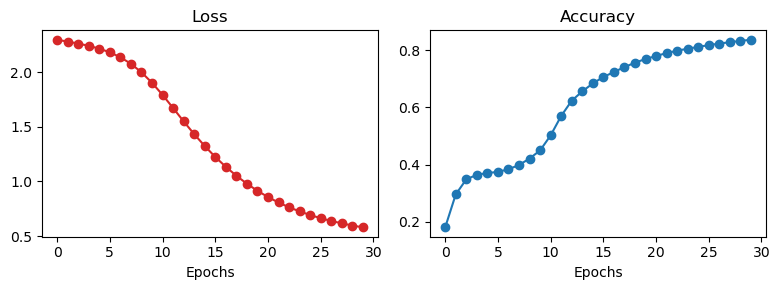

In [10]:
# Plot the loss and accuracy across epochs.
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(all_train_loss, "o-", c="tab:red")
plt.title("Loss")
plt.xlabel("Epochs")
plt.subplot(1, 2, 2)
plt.plot(all_train_accuracy, "o-", c="tab:blue")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.tight_layout()
plt.show()

### Cell 7: TEST THE MODEL!

In [11]:
# Test! Obtain the loss and the accuracy on the test set.
# Note the similarities and differences between training and testing.

# Prepare the model for evaluation.
model.eval()
test_loss = 0.0
test_accuracy = 0.0

# Since we aren't training the model, we make this specification.
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        pred = model(images)
        loss = loss_func(pred, labels)
        test_loss += loss.item()

        pred_classes = torch.argmax(pred, dim=1)
        test_accuracy += torch.sum(pred_classes == labels).item()

    test_loss /= len(test_loader)
    test_accuracy /= (batch_size * len(test_loader))

print("Test results:")
print("Test loss: " + str(test_loss))
print("Test accuracy: " + str(test_accuracy))

Test results:
Test loss: 0.5466555449095639
Test accuracy: 0.845028409090909


### Plot ReLU

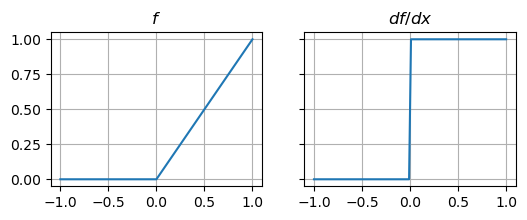

In [12]:
x = torch.from_numpy(np.arange(-1, 1.01, 0.01)).float()
f = nn.ReLU()
y = f(x)
yp = np.gradient(y, x)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6, 2))

axs[0].plot(x, y)
axs[0].set_title('$f$')
axs[0].grid(True)

axs[1].plot(x, yp)
axs[1].set_title('$df/dx$')
axs[1].grid(True)

plt.savefig('8fig1.png', dpi=150)
plt.show()